In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
246  246 2023-06-26    GOOG  ACT  121.466003  122.720001  118.989998   
247  247 2023-06-27    GOOG  ACT  117.839996  119.894997  116.910004   
248  248 2023-06-28    GOOG  ACT  117.959999  121.269997  117.599998   
249  249 2023-06-29    GOOG  ACT  120.089996  120.910004  119.209999   
250  250 2023-06-30    GOOG  ACT  121.099998  122.029999  120.879997   

          Close    Volume  
246  119.089996  23185000  
247  119.010002  27221700  
248  121.080002  19753100  
249  120.010002  18517500  
250  120.970001  23865800  


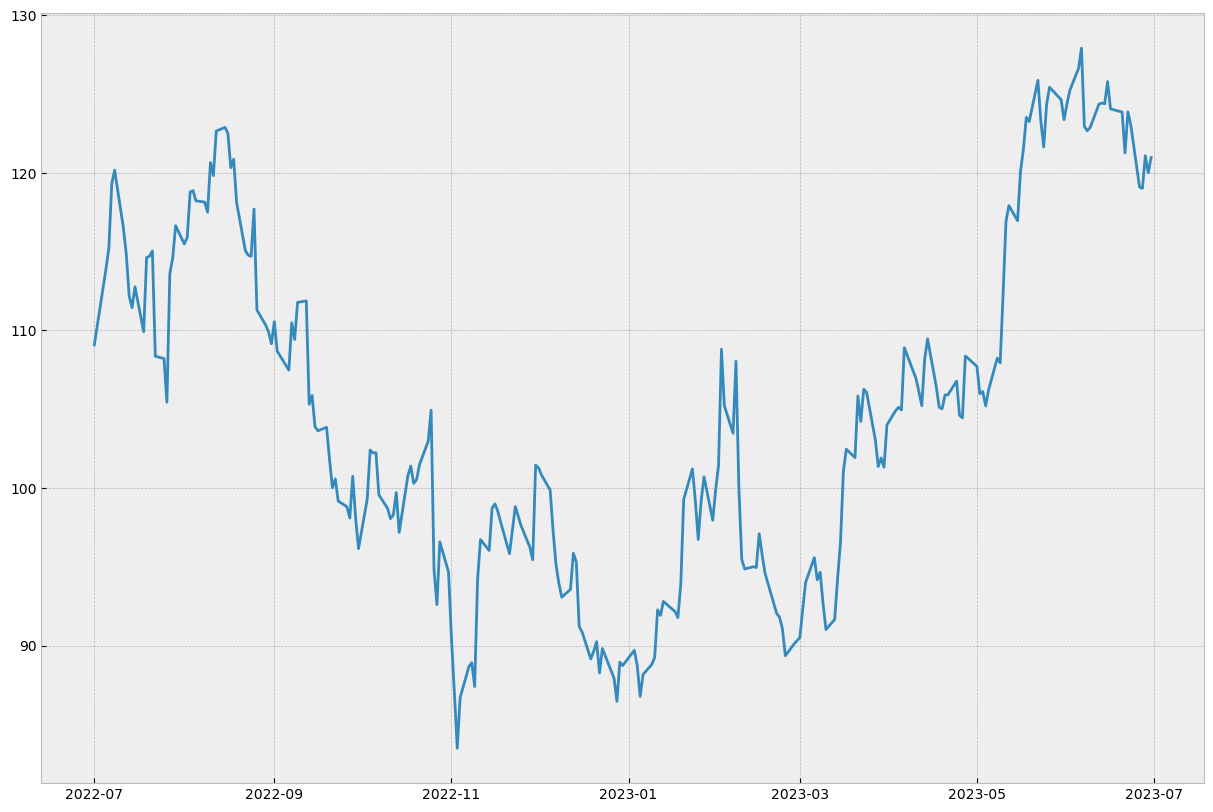

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

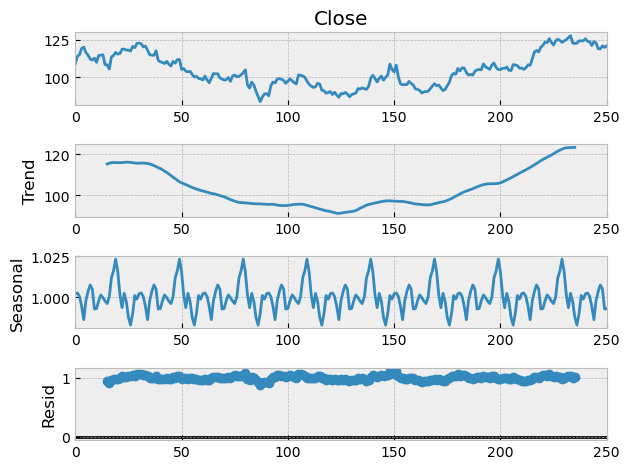

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

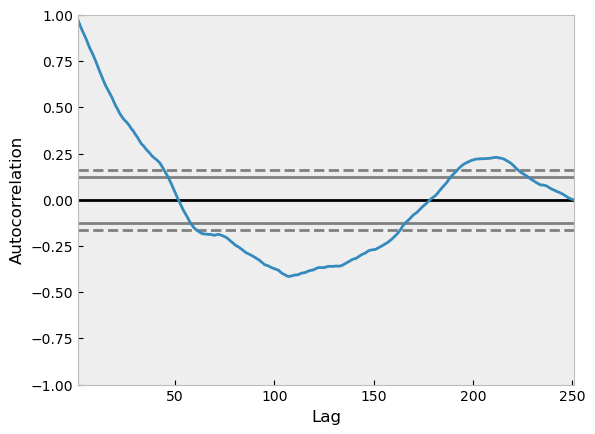

In [4]:
pd.plotting.autocorrelation_plot(data["Close"])

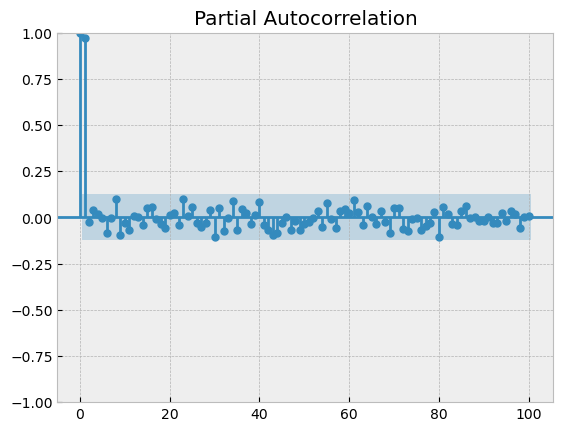

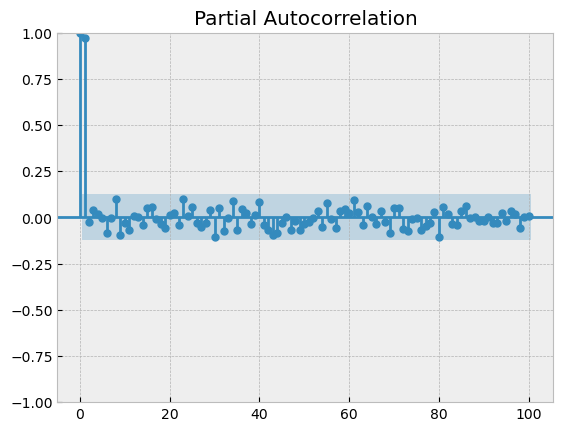

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=100, method='ywm')

In [6]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

# Annahme: Sie haben Ihre Zeitreihendaten in einem DataFrame namens 'data' geladen

# Die Zeitreihendaten in eine eindimensionale NumPy-Array-ähnliche Struktur umwandeln
y = np.array(data['Close'])

# AutoARIMA-Modell erstellen und anpassen, um die optimalen Parameterwerte zu ermitteln
model = auto_arima(y, seasonal=False, trace=True)

# Die optimalen Parameterwerte für P, D und Q ausgeben
print(f"Optimale Werte für P, D und Q: {model.order}")
p, d, q = model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1152.041, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1154.030, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1154.028, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1150.139, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1155.205, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.957 seconds
Optimale Werte für P, D und Q: (0, 1, 0)


In [7]:
#p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -574.069
Date:                Sun, 09 Jul 2023   AIC                           1150.139
Time:                        11:12:16   BIC                           1153.660
Sample:                             0   HQIC                          1151.556
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.7816      0.367     15.739      0.000       5.062       6.502
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                41.52
Prob(Q):                              0.92   Pr

In [8]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      109.081001
2      113.887001
3      115.213501
4      119.306000
          ...    
246    123.019997
247    119.089996
248    119.010002
249    121.080002
250    120.010002
Name: predicted_mean, Length: 251, dtype: float64


In [9]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -635.300
Date:                            Sun, 09 Jul 2023   AIC                           1272.600
Time:                                    11:12:16   BIC                           1276.072
Sample:                                         0   HQIC                          1273.999
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        12.1919      0.897     13.598      0.000      10.435      13.949
Ljung-Box (L1) (Q):                

In [10]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

251    120.919998
252    122.330002
253    120.599998
254    120.389999
255    117.800003
256    120.410004
257    119.559998
258    115.629997
259    115.550003
260    117.620003
261    116.550003
262    117.510002
263    117.459999
264    118.870003
265    117.139999
266    116.930000
267    114.340004
268    116.950005
269    116.099998
270    112.169998
271    112.090004
272    114.160004
273    113.090004
274    114.050003
275    114.000000
276    115.410004
277    113.680000
278    113.470001
279    110.880005
280    113.490005
281    112.639999
Name: predicted_mean, dtype: float64


<Axes: >

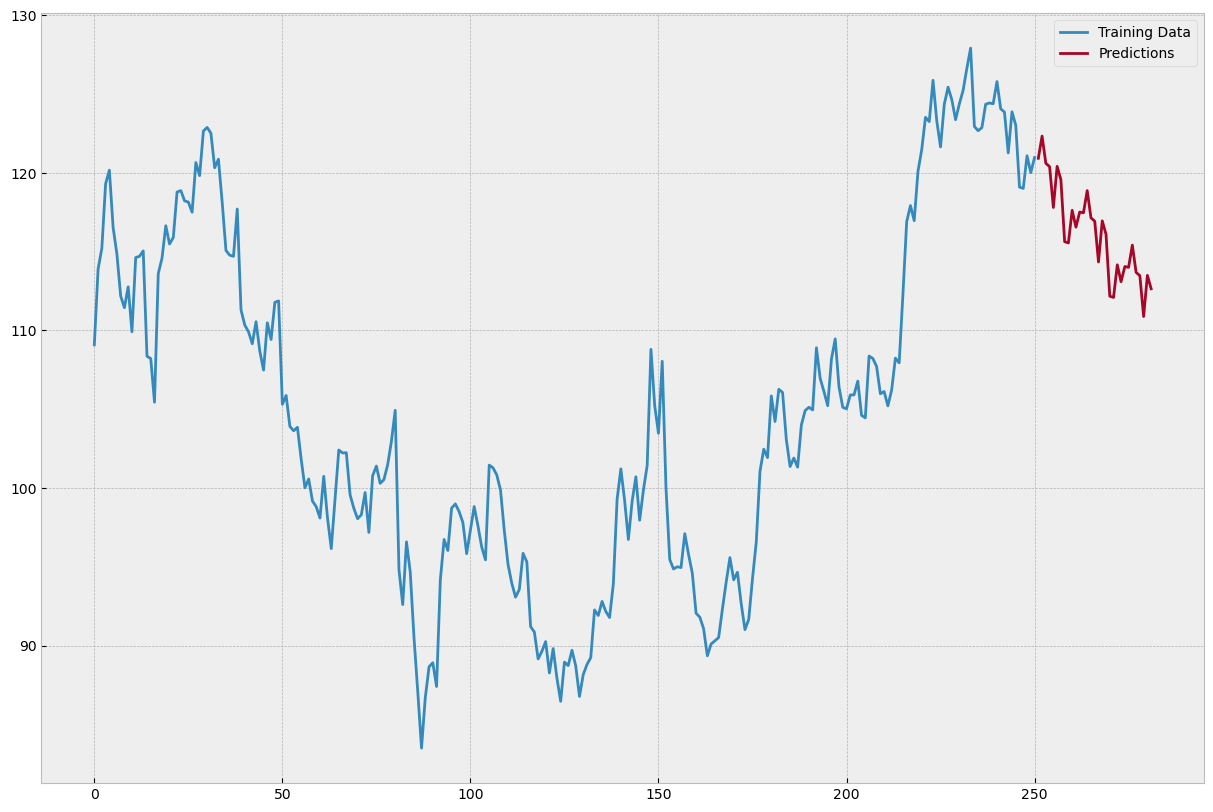

In [11]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

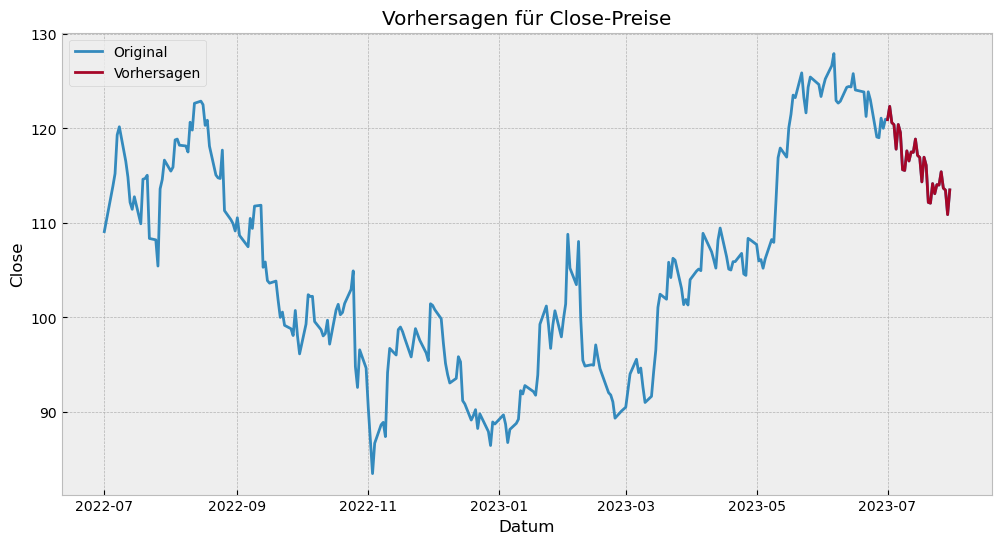

In [21]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
data_extended_key = data_extended

In [24]:
data_extended_key

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
0,0.0,2022-07-01,GOOG,Act_GOOG,108.336998,109.806351,107.105003,109.081001,31028000.0,NaN,GOOG_2022-07-01_Act_GOOG
1,1.0,2022-07-05,GOOG,Act_GOOG,107.514503,114.052597,106.249496,113.887001,36398000.0,NaN,GOOG_2022-07-05_Act_GOOG
2,2.0,2022-07-06,GOOG,Act_GOOG,114.092003,116.351997,112.250504,115.213501,28852000.0,NaN,GOOG_2022-07-06_Act_GOOG
3,3.0,2022-07-07,GOOG,Act_GOOG,116.008003,119.862000,115.533997,119.306000,32184000.0,NaN,GOOG_2022-07-07_Act_GOOG
4,4.0,2022-07-08,GOOG,Act_GOOG,117.550003,120.434998,117.514000,120.168503,29082000.0,NaN,GOOG_2022-07-08_Act_GOOG
...,...,...,...,...,...,...,...,...,...,...,...
276,NaN,2023-07-26,GOOG,Arima_GOOG,NaN,NaN,NaN,115.410004,NaN,2023-07-01,GOOG_2023-07-26_Arima_GOOG
277,NaN,2023-07-27,GOOG,Arima_GOOG,NaN,NaN,NaN,113.680000,NaN,2023-07-01,GOOG_2023-07-27_Arima_GOOG
278,NaN,2023-07-28,GOOG,Arima_GOOG,NaN,NaN,NaN,113.470001,NaN,2023-07-01,GOOG_2023-07-28_Arima_GOOG
279,NaN,2023-07-29,GOOG,Arima_GOOG,NaN,NaN,NaN,110.880005,NaN,2023-07-01,GOOG_2023-07-29_Arima_GOOG


In [23]:
import numpy as np

# Key einbinden
company = data.loc[0]['Company']
data_extended_key['Company'] = company
data_extended_key['Type'] = data_extended_key['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended_key.loc[data_extended_key['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended_key['Key'] = data_extended_key['Company'] + '_' + data_extended_key['Date'].astype(str) + '_' + data_extended_key['Type']


In [15]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

In [16]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended_key])



In [17]:
# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

In [18]:
# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 1006 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [19]:
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Forecast_Date,Key
0,137.0,2023-01-18,MSFT,Act_MSFT,241.57,242.38,235.52,235.809998,30028700.0,None,MSFT_2023-01-18_Act_MSFT
1,229.0,2023-05-31,MSFT,Act_MSFT,332.29,335.94,327.33,328.390015,45950600.0,None,MSFT_2023-05-31_Act_MSFT
2,NaN,2023-06-14,GOOG,Arima_GOOG,NaN,NaN,NaN,123.542942,NaN,2023-06-01,GOOG_2023-06-14_Arima_GOOG
3,NaN,2023-06-15,GOOG,Arima_GOOG,NaN,NaN,NaN,124.027303,NaN,2023-06-01,GOOG_2023-06-15_Arima_GOOG
4,NaN,2023-06-16,GOOG,Arima_GOOG,NaN,NaN,NaN,123.773450,NaN,2023-06-01,GOOG_2023-06-16_Arima_GOOG
...,...,...,...,...,...,...,...,...,...,...,...
1282,NaN,2023-07-26,GOOG,LSTM_GOOG,NaN,NaN,NaN,100.740776,NaN,2023-07-01,GOOG_2023-07-26_LSTM_GOOG
1283,NaN,2023-07-27,GOOG,LSTM_GOOG,NaN,NaN,NaN,100.825043,NaN,2023-07-01,GOOG_2023-07-27_LSTM_GOOG
1284,NaN,2023-07-28,GOOG,LSTM_GOOG,NaN,NaN,NaN,100.914940,NaN,2023-07-01,GOOG_2023-07-28_LSTM_GOOG
1285,NaN,2023-07-29,GOOG,LSTM_GOOG,NaN,NaN,NaN,101.007034,NaN,2023-07-01,GOOG_2023-07-29_LSTM_GOOG
